In [1]:
# Importing the required library
import gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
import numpy as np
import random
import math

In [2]:
# selecting the available device (cpu/gpu)

use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")

print(device)

cpu


In [3]:
# Creating the CartPole-v0 environment

env = gym.make('CartPole-v0')

In [4]:
# setting the seed value for reproducibility

seed = 100
env.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

In [5]:
# Fetching the number of states and actions
#number_of_states = env.observation_space.n
number_of_states = env.observation_space.shape[0]
number_of_actions = env.action_space.n
# checking the total number of states and action
print('Total number of States : {}'.format(number_of_states)) 
print('Total number of Actions : {}'.format(number_of_actions))

Total number of States : 4
Total number of Actions : 2


In [6]:
# Setting the Hyper parameter Values for Q Learning

NUMBER_OF_EPISODES = 500
MAX_STEPS = 1000
LEARNING_RATE = 0.01
DISCOUNT_FACTOR = 0.99
HIDDEN_LAYER_SIZE = 64

EGREEDY = 0.9
EGREEDY_FINAL = 0.02
EGREEDY_DECAY = 500

REPLAY_BUFFER_SIZE = 6000
BATCH_SIZE = 32

UPDATE_TARGET_FREQUENCY = 100

In [7]:
def calculate_epsilon(steps_done):
    """
    Decays eplison with increasing steps
    Parameter:
    steps_done (int) : number of steps completed
    Returns:
    int - decayed epsilon
    """
    epsilon = EGREEDY_FINAL + (EGREEDY - EGREEDY_FINAL) * \
              math.exp(-1. * steps_done / EGREEDY_DECAY )
    return epsilon

In [8]:
# Deep Q Network Model Architecture

class DQN(nn.Module):
    def __init__(self , hidden_layer_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.fc1 = nn.Linear(number_of_states,self.hidden_layer_size)
        self.fc2 = nn.Linear(self.hidden_layer_size,number_of_actions)

    def forward(self, x):
        output = torch.tanh(self.fc1(x))
        output = self.fc2(output)
        return output

In [9]:
class ExperienceReplay(object):
    def __init__(self , capacity):
        
        self.capacity = capacity
        self.buffer = []
        self.pointer = 0
    
    def push(self , state, action, new_state, reward, done):
        experience = (state, action, new_state, reward, done)
        
        if self.pointer >= len(self.buffer):
            self.buffer.append(experience)
        else:
            self.buffer[self.pointer] = experience
        
        self.pointer = (self.pointer + 1) % self.capacity
        
    def sample(self , batch_size):
        return zip(*random.sample(self.buffer , batch_size))
    
    def __len__(self):
        return len(self.buffer)    

In [10]:
# Instantiating the ExperienceReplay
memory = ExperienceReplay(REPLAY_BUFFER_SIZE)

In [11]:
# Building the brain of the network i.e. the DQN Agent

class DQN_Agent(object):
    def __init__(self):
        
        self.dqn = DQN(HIDDEN_LAYER_SIZE).to(device)
        self.target_dqn = DQN(HIDDEN_LAYER_SIZE).to(device)
        
        self.criterion = torch.nn.MSELoss()
        
        self.optimizer = optim.Adam(params=self.dqn.parameters() , lr=LEARNING_RATE)
        
        self.target_dqn_update_counter = 0
    
    def select_action(self,state,EGREEDY):
        
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > EGREEDY:      
            
            with torch.no_grad():
                
                state = torch.Tensor(state).to(device)
                q_values = self.dqn(state)
                action = torch.max(q_values,0)[1]
                action = action.item()        
        else:
            action = env.action_space.sample()
        
        return action
    
    def optimize(self):
        
        if (BATCH_SIZE > len(memory)):
            return
        
        state, action, new_state, reward, done = memory.sample(BATCH_SIZE)
        
        state = torch.Tensor(state).to(device)
        new_state = torch.Tensor(new_state).to(device)
        reward = torch.Tensor(reward).to(device)
        action = torch.LongTensor(action).to(device)
        done = torch.Tensor(done).to(device)
        
        # select action : get the index associated with max q value from prediction network
        new_state_indxs = self.dqn(new_state).detach() 
        max_new_state_indxs = torch.max(new_state_indxs, 1)[1] # to get the max new state indexes
        
        
        # Using the best action from the prediction nn get the max new state value in target dqn
        new_state_values = self.target_dqn(new_state).detach()
        max_new_state_values = new_state_values.gather(1, max_new_state_indxs.unsqueeze(1)).squeeze(1)
        
        
        target_value = reward + (1 - done) * DISCOUNT_FACTOR * max_new_state_values #when done = 1 then target = reward
        
        predicted_value = self.dqn(state).gather(1, action.unsqueeze(1)).squeeze(1)
        
        
        loss = self.criterion(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.target_dqn_update_counter % UPDATE_TARGET_FREQUENCY == 0:
            self.target_dqn.load_state_dict(self.dqn.state_dict())
        
        self.target_dqn_update_counter += 1

In [12]:
# Instantiating the DQN Agent
dqn_agent = DQN_Agent()

In [13]:
steps_total = []
steps_counter = 0
for episode in range(NUMBER_OF_EPISODES):
    
    state = env.reset()
    done = False

    step = 0

    for i in range(MAX_STEPS):
        step += 1
        steps_counter += 1
        
        EGREEDY = calculate_epsilon(steps_counter)

        action = dqn_agent.select_action(state, EGREEDY)
            
        new_state, reward, done, info = env.step(action)

        memory.push(state, action, new_state, reward, done)


        dqn_agent.optimize()
        
        state = new_state

        if done:
            steps_total.append(step)
            break

In [14]:
print("Average reward: %.2f" % (sum(steps_total)/NUMBER_OF_EPISODES))
print("Average reward (last 100 episodes): %.2f" % (sum(steps_total[-100:])/100))

Average reward: 174.09
Average reward (last 100 episodes): 186.06


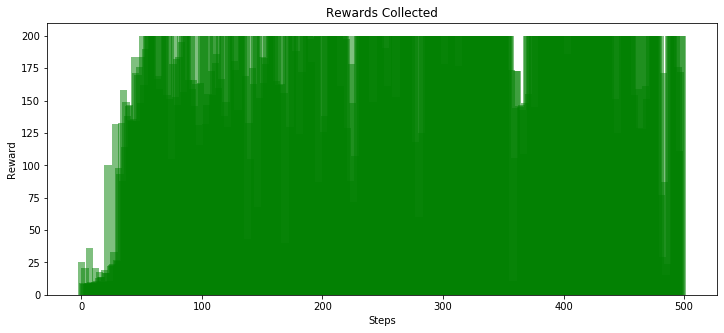

In [16]:
plt.figure(figsize=(12,5))
plt.title("Rewards Collected")
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.bar(np.arange(len(steps_total)), steps_total, alpha=0.5, color='green', width=6)
plt.show()